In [1]:
import os
import pathlib
import time

import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
TIME_POINTS_NUM = 800000
PERIOD = 0.02
TIME_STEP = PERIOD / TIME_POINTS_NUM
#time_vector = np.arange(0, PERIOD, TIME_STEP)
time_vector = np.linspace(0, 2 * np.pi, TIME_POINTS_NUM)

In [4]:
time_vector.shape

(800000,)

In [5]:
!ls ../input/

metadata_test.csv   sample_submission.csv  test.parquet.zip  train.parquet.zip
metadata_train.csv  test		   train


In [6]:
metadata_train_df = pd.read_csv('../input/metadata_train.csv')

In [7]:
metadata_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8712 entries, 0 to 8711
Data columns (total 4 columns):
signal_id         8712 non-null int64
id_measurement    8712 non-null int64
phase             8712 non-null int64
target            8712 non-null int64
dtypes: int64(4)
memory usage: 272.3 KB


In [8]:
metadata_train_df.describe()

,signal_id,id_measurement,phase,target
count,8712.000000,8712.000000,8712.000000,8712.000000
mean,4355.500000,1451.500000,1.000000,0.060262
std,2515.082106,838.360658,0.816543,0.237985
min,0.000000,0.000000,0.000000,0.000000
25%,2177.750000,725.750000,0.000000,0.000000
50%,4355.500000,1451.500000,1.000000,0.000000
75%,6533.250000,2177.250000,2.000000,0.000000
max,8711.000000,2903.000000,2.000000,1.000000


In [9]:
metadata_train_df.head()

,signal_id,id_measurement,phase,target
0,0,0,0,0
1,1,0,1,0
2,2,0,2,0
3,3,1,0,1
4,4,1,1,1


In [10]:
metadata_train_df.tail()

,signal_id,id_measurement,phase,target
8707,8707,2902,1,0
8708,8708,2902,2,0
8709,8709,2903,0,0
8710,8710,2903,1,0
8711,8711,2903,2,0


In [11]:
#%%timeit
train_df = pq.read_pandas('../input/train/train.parquet').to_pandas()

In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Columns: 8712 entries, 0 to 8711
dtypes: int8(8712)
memory usage: 6.5 GB


In [13]:
train_df.columns[:5]

Index(['0', '1', '2', '3', '4'], dtype='object')

In [14]:
subset_train_df = pq.read_pandas('../input/train/train.parquet', columns=[str(i) for i in range(5)]).to_pandas()

In [15]:
subset_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Data columns (total 5 columns):
0    800000 non-null int8
1    800000 non-null int8
2    800000 non-null int8
3    800000 non-null int8
4    800000 non-null int8
dtypes: int8(5)
memory usage: 3.8 MB


In [16]:
subset_train_df.head()

,0,1,2,3,4
0,18,1,-19,-16,-5
1,18,0,-19,-17,-6
2,17,-1,-20,-17,-6
3,18,1,-19,-16,-5
4,18,0,-19,-16,-5


In [17]:
metadata_train_df.signal_id.unique().shape

(8712,)

In [18]:
metadata_train_df.id_measurement.unique().shape

(2904,)

In [19]:
metadata_train_df.signal_id.unique().shape[0] == 3 * metadata_train_df.id_measurement.unique().shape[0]

True

Первая идея, с которой всё началось - взять идеальную синусойду (которая и описывает значение амплитуды в зависимости от фазы). Далее сразу же встал вопрос - а где взять амплитудный коэффицент для идеальной синусойды? Ответ очевиден: вычислить её как sample mean. Ну или sample median (mode) и.т. - среднее геометрическое, гармоническое и что там ещё. Причём и взять и от всех сигналов, и только от "неаварийных" и только от "аварийных". Далее мы можем вычислять разности в каждой  "измерительной" точке между "идеальной" амплитудой и "реальной". А далее можно считать квадратичные отклонения, складывать их, или абсолютные отклонения, складывать их. Если же окажеться что амплитуды силно разняться (разные энергии переносяться по различным линиям электропередач), то возможно надо  поприводить их всех к однинаковому масштабу (MinMaxScaler и т.д.), либо же разбивать на какието бины. Если возможно, то найти count различных значений амплитуд для каждого сигнала (или груп сигналов - например "аварийных" и "неаварийных" или ещё каких либо групп, например бинов по максимальным/минимальным значениям), построить гистограммы. А так же построить гистограммы средних/медиан/мод для всех сигналов (либо их бинов). Т.е. найти средние (медиану, моду) для каждого сигнала, и построить гистограммы для этих значений. Найти так же дисперсии/среднеквадратичные отклонения/квантили для всех вышеперичисленных категорий сигналов, например отдельно для "аварийных" и "неаварийных") вдруг они как раз статистически значимы.

In [20]:
train_df.columns[:5]

Index(['0', '1', '2', '3', '4'], dtype='object')

In [21]:
one_signal_0 = train_df.iloc[0, :]

In [22]:
one_signal_0.shape

(8712,)

In [23]:
one_signal_0 = train_df.iloc[:, 0]

In [24]:
one_signal_0.shape

(800000,)

In [25]:
type(one_signal_0)

pandas.core.series.Series

In [27]:
time_points = np.arange(TIME_POINTS_NUM)

In [28]:
time_points.shape

(800000,)

In [113]:
#fig = plt.figure(figsize=(18, 16))
#ax = fig.add_subplot(111)
#ax.plot(time_vector, one_signal_0)

In [30]:
one_signal_1 = train_df.iloc[:, 1]

In [112]:
#fig = plt.figure(figsize=(18, 16))
#ax = fig.add_subplot(111)
#ax.plot(time_vector, one_signal_1)

In [32]:
one_signal_0_abs = one_signal_0.map(np.abs)

In [33]:
one_signal_0_mean_amplitude = one_signal_0_abs.sum() / one_signal_0.shape[0]
one_signal_0_max_amplitude = one_signal_0_abs.max()
one_signal_0_min_amplitude = one_signal_0_abs.min()
one_signal_0_mode_amplitude = one_signal_0_abs.mode().iloc[0]
one_signal_0_median_amplitude = one_signal_0_abs.median()

In [34]:
#one_signal_0_abs.mode?

In [35]:
print(one_signal_0_mean_amplitude)
print(one_signal_0_min_amplitude)
print(one_signal_0_max_amplitude)
print(one_signal_0_mode_amplitude)
print(one_signal_0_median_amplitude)

12.57544875
0
39
19
13.0


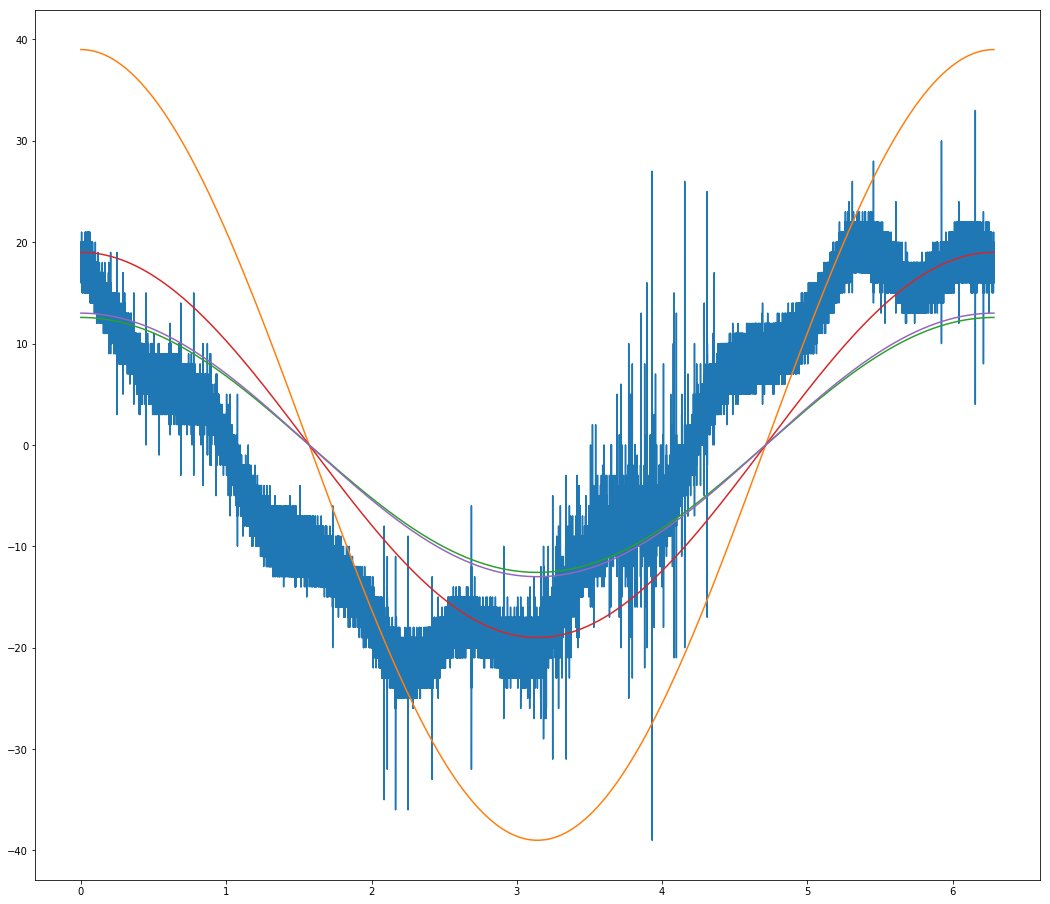

In [36]:
fig = plt.figure(figsize=(18, 16))
ax = fig.add_subplot(111)
#ax.plot(time_points, one_signal_0)
#ax.plot(time_points, one_signal_0_max_amplitude * np.cos(time_vector))
#ax.plot(time_points, one_signal_0_mean_amplitude * np.cos(time_vector))
#ax.plot(time_points, one_signal_0_mode_amplitude * np.cos(time_vector))

ax.plot(time_vector, one_signal_0)
ax.plot(time_vector, one_signal_0_max_amplitude * np.cos(time_vector))
ax.plot(time_vector, one_signal_0_mean_amplitude * np.cos(time_vector))
ax.plot(time_vector, one_signal_0_mode_amplitude * np.cos(time_vector))
ax.plot(time_vector, one_signal_0_median_amplitude * np.cos(time_vector))

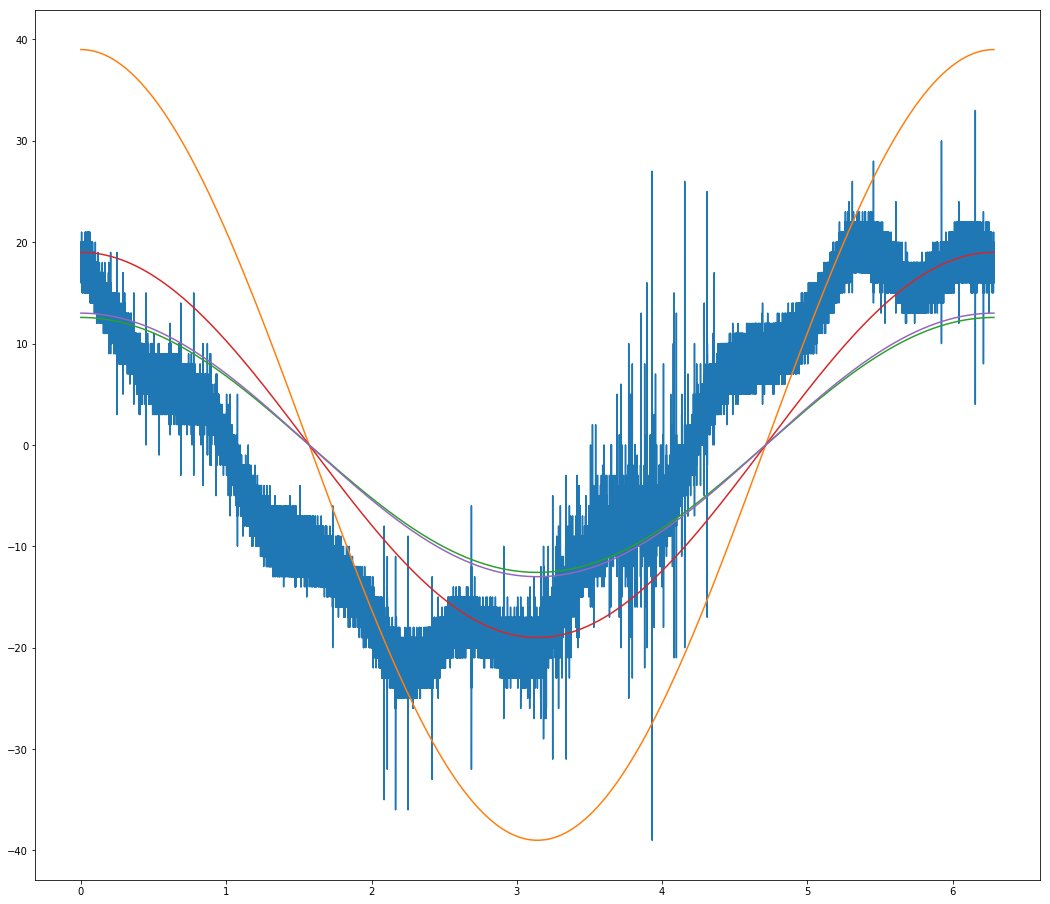

In [37]:
fig = plt.figure(figsize=(18, 16))
ax = fig.add_subplot(111)
#ax.plot(time_points, one_signal_0)
#ax.plot(time_points, one_signal_0_max_amplitude * np.cos(time_vector))
#ax.plot(time_points, one_signal_0_mean_amplitude * np.cos(time_vector))
#ax.plot(time_points, one_signal_0_mode_amplitude * np.cos(time_vector))
time_vector_0 = time_vector + np.pi / 2
ax.plot(time_vector, one_signal_0)
ax.plot(time_vector, one_signal_0_max_amplitude * np.sin(time_vector_0))
ax.plot(time_vector, one_signal_0_mean_amplitude * np.sin(time_vector_0))
ax.plot(time_vector, one_signal_0_mode_amplitude * np.sin(time_vector_0))
ax.plot(time_vector, one_signal_0_median_amplitude * np.sin(time_vector_0))

In [38]:
#np.sin?

In [39]:
one_signal_1_abs = one_signal_1.map(np.abs)

In [40]:
one_signal_1_mean_amplitude = one_signal_1_abs.sum() / one_signal_1.shape[0]
one_signal_1_max_amplitude = one_signal_1_abs.max()
one_signal_1_min_amplitude = one_signal_1_abs.min()
one_signal_1_mode_amplitude = one_signal_1_abs.mode().iloc[0]
one_signal_1_median_amplitude = one_signal_1_abs.median()

In [41]:
print(one_signal_1_mean_amplitude)
print(one_signal_1_min_amplitude)
print(one_signal_1_max_amplitude)
print(one_signal_1_mode_amplitude)
print(one_signal_1_median_amplitude)

11.7918075
0
30
17
12.0


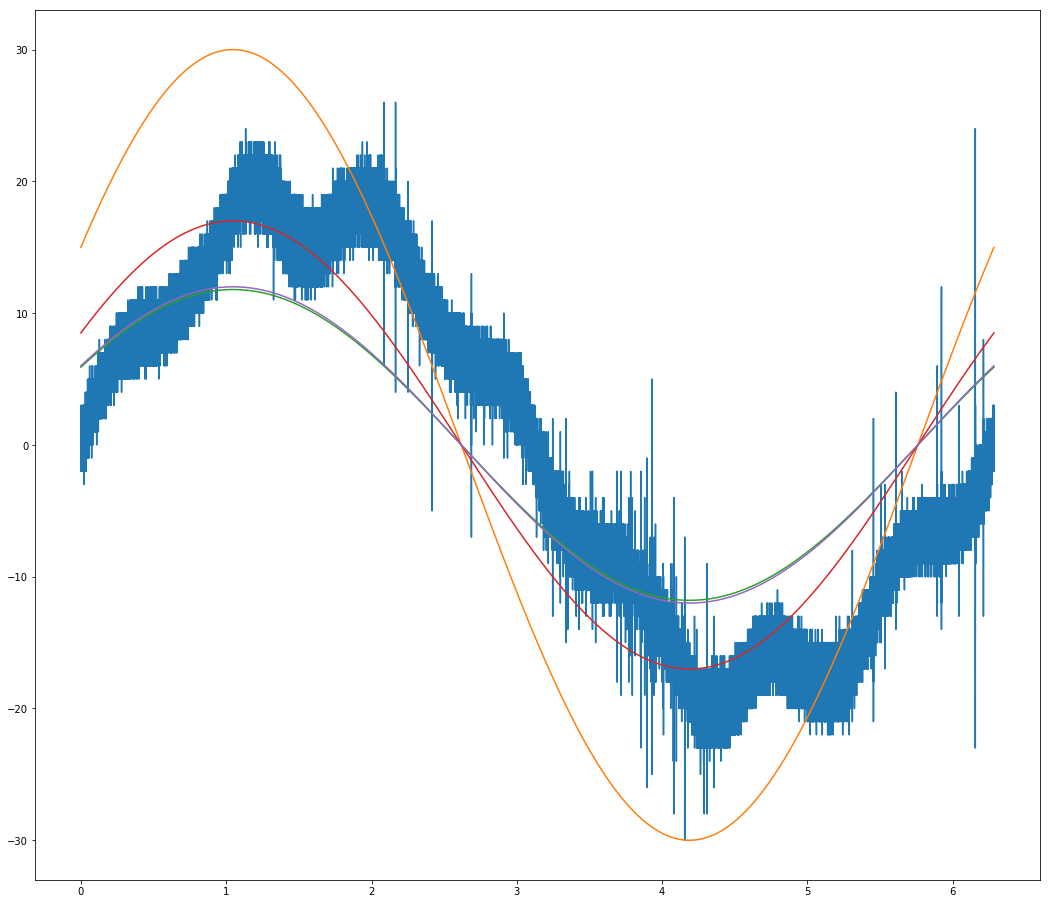

In [90]:
fig = plt.figure(figsize=(18, 16))
ax = fig.add_subplot(111)
#ax.plot(time_points, one_signal_1)
#ax.plot(time_points, one_signal_1_max_amplitude * np.cos(time_vector + 2 * np.pi / 3))
#ax.plot(time_points, one_signal_1_mean_amplitude * np.cos(time_vector + 2 * np.pi / 3))
#ax.plot(time_points, one_signal_1_max_amplitude * np.sin(time_vector))
#ax.plot(time_points, one_signal_1_mean_amplitude * np.sin(time_vector))
#ax.plot(time_points, one_signal_1_mode_amplitude * np.sin(time_vector))

time_vector_1 = time_vector - np.pi / 2 + 2 * np.pi / 3
ax.plot(time_vector, one_signal_1)
#ax.plot(time_points, one_signal_1_max_amplitude * np.cos(time_vector + 2 * np.pi / 3))
#ax.plot(time_points, one_signal_1_mean_amplitude * np.cos(time_vector + 2 * np.pi / 3))
ax.plot(time_vector, one_signal_1_max_amplitude * np.sin(time_vector_1))
ax.plot(time_vector, one_signal_1_mean_amplitude * np.sin(time_vector_1))
ax.plot(time_vector, one_signal_1_mode_amplitude * np.sin(time_vector_1))
ax.plot(time_vector, one_signal_1_median_amplitude * np.sin(time_vector_1))
#time_vector_1 = time_vector + np.pi / 3
#ax.plot(time_vector, one_signal_1_max_amplitude * np.cos(time_vector_1))
#ax.plot(time_vector, one_signal_1_mean_amplitude * np.cos(time_vector_1))
#ax.plot(time_vector, one_signal_1_mode_amplitude * np.cos(time_vector_1))
#ax.plot(time_vector, one_signal_1_median_amplitude * np.cos(time_vector_1))
#ax.plot(time_vector, one_signal_1_max_amplitude * np.cos(time_vector))
#ax.plot(time_vector, one_signal_1_mean_amplitude * np.cos(time_vector))
#ax.plot(time_vector, one_signal_1_mode_amplitude * np.cos(time_vector))

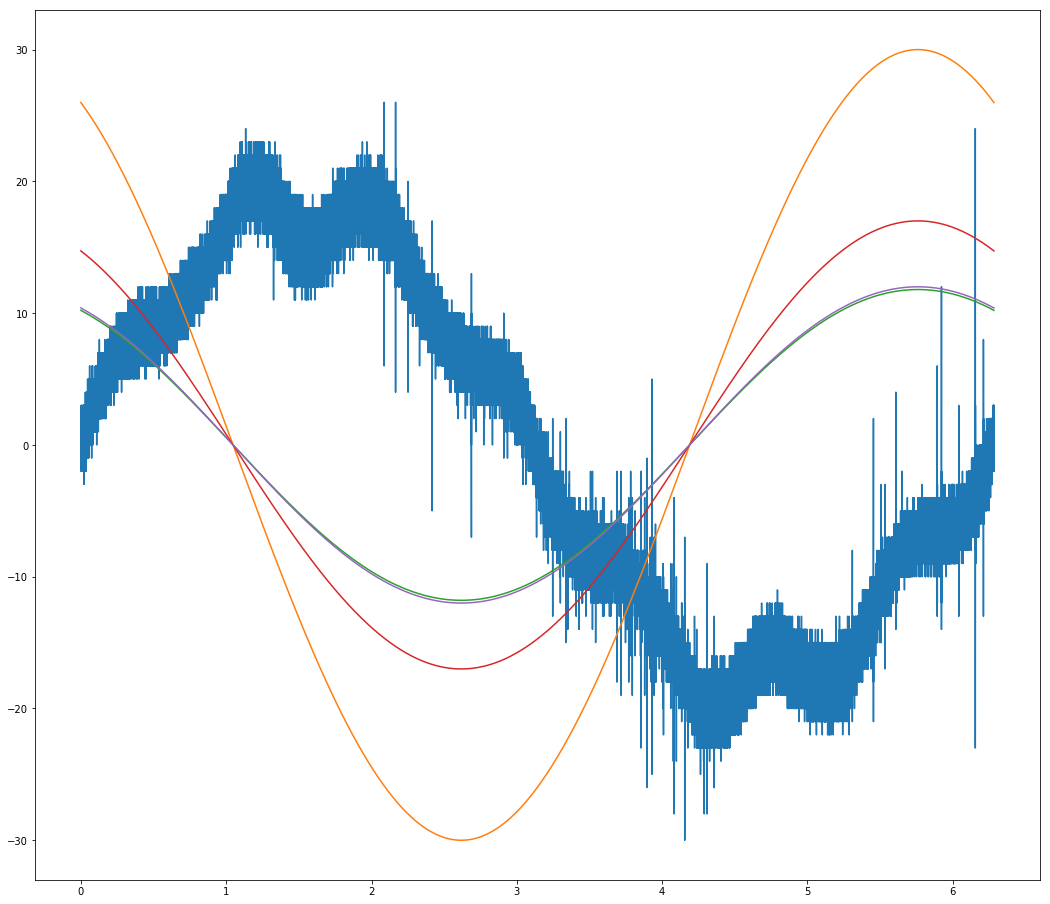

In [43]:
fig = plt.figure(figsize=(18, 16))
ax = fig.add_subplot(111)
#ax.plot(time_points, one_signal_1)
#ax.plot(time_points, one_signal_1_max_amplitude * np.cos(time_vector + 2 * np.pi / 3))
#ax.plot(time_points, one_signal_1_mean_amplitude * np.cos(time_vector + 2 * np.pi / 3))
#ax.plot(time_points, one_signal_1_max_amplitude * np.sin(time_vector))
#ax.plot(time_points, one_signal_1_mean_amplitude * np.sin(time_vector))
#ax.plot(time_points, one_signal_1_mode_amplitude * np.sin(time_vector))

ax.plot(time_vector, one_signal_1)
#ax.plot(time_points, one_signal_1_max_amplitude * np.cos(time_vector + 2 * np.pi / 3))
#ax.plot(time_points, one_signal_1_mean_amplitude * np.cos(time_vector + 2 * np.pi / 3))
##ax.plot(time_vector, one_signal_1_max_amplitude * np.sin(time_vector))
##ax.plot(time_vector, one_signal_1_mean_amplitude * np.sin(time_vector))
##ax.plot(time_vector, one_signal_1_mode_amplitude * np.sin(time_vector))
##ax.plot(time_vector, one_signal_1_median_amplitude * np.sin(time_vector))
time_vector_1 = time_vector + 2 * np.pi / 3
ax.plot(time_vector, one_signal_1_max_amplitude * np.sin(time_vector_1))
ax.plot(time_vector, one_signal_1_mean_amplitude * np.sin(time_vector_1))
ax.plot(time_vector, one_signal_1_mode_amplitude * np.sin(time_vector_1))
ax.plot(time_vector, one_signal_1_median_amplitude * np.sin(time_vector_1))
#ax.plot(time_vector, one_signal_1_max_amplitude * np.cos(time_vector))
#ax.plot(time_vector, one_signal_1_mean_amplitude * np.cos(time_vector))
#ax.plot(time_vector, one_signal_1_mode_amplitude * np.cos(time_vector))

In [44]:
#train_signals_df_mode = train_df.mode()

In [111]:
#print(train_signals_df_mode)

In [46]:
one_signal_0_abs.median()

13.0

In [47]:
one_signal_0_abs.unique().shape

(37,)

In [48]:
one_signal_1_abs.unique().shape

(30,)

In [49]:
one_signal_0.unique().shape

(66,)

In [50]:
one_signal_1.unique().shape

(55,)

In [51]:
#train_df_abs = train_df.applymap(np.abs)

In [52]:
one_signal_2 = train_df.iloc[:, 2]

In [110]:
#one_signal_2 > 0

In [54]:
one_signal_2_negatives = one_signal_2[one_signal_2 <= 0]

In [55]:
one_signal_2_negatives.shape

(404711,)

In [56]:
#%%timeit
one_signal_2_abs = one_signal_2.map(np.abs)

In [57]:
%%timeit
one_signal_2_abs = one_signal_2[one_signal_2 >= 0]
one_signal_2_abs = one_signal_2[one_signal_2 < 0]

3.67 ms ± 72.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [58]:
one_signal_2_abs.shape

(800000,)

In [109]:
#one_signal_2

In [108]:
#one_signal_2_abs

In [61]:
one_signal_2_mean_amplitude = one_signal_2_abs.sum() / one_signal_2.shape[0]
one_signal_2_max_amplitude = one_signal_2_abs.max()
one_signal_2_min_amplitude = one_signal_2_abs.min()
one_signal_2_mode_amplitude = one_signal_2_abs.mode().iloc[0]
one_signal_2_median_amplitude = one_signal_2_abs.median()

In [62]:
print(one_signal_2_mean_amplitude)
print(one_signal_2_min_amplitude)
print(one_signal_2_max_amplitude)
print(one_signal_2_mode_amplitude)
print(one_signal_2_median_amplitude)

12.353285
0
39
18
13.0


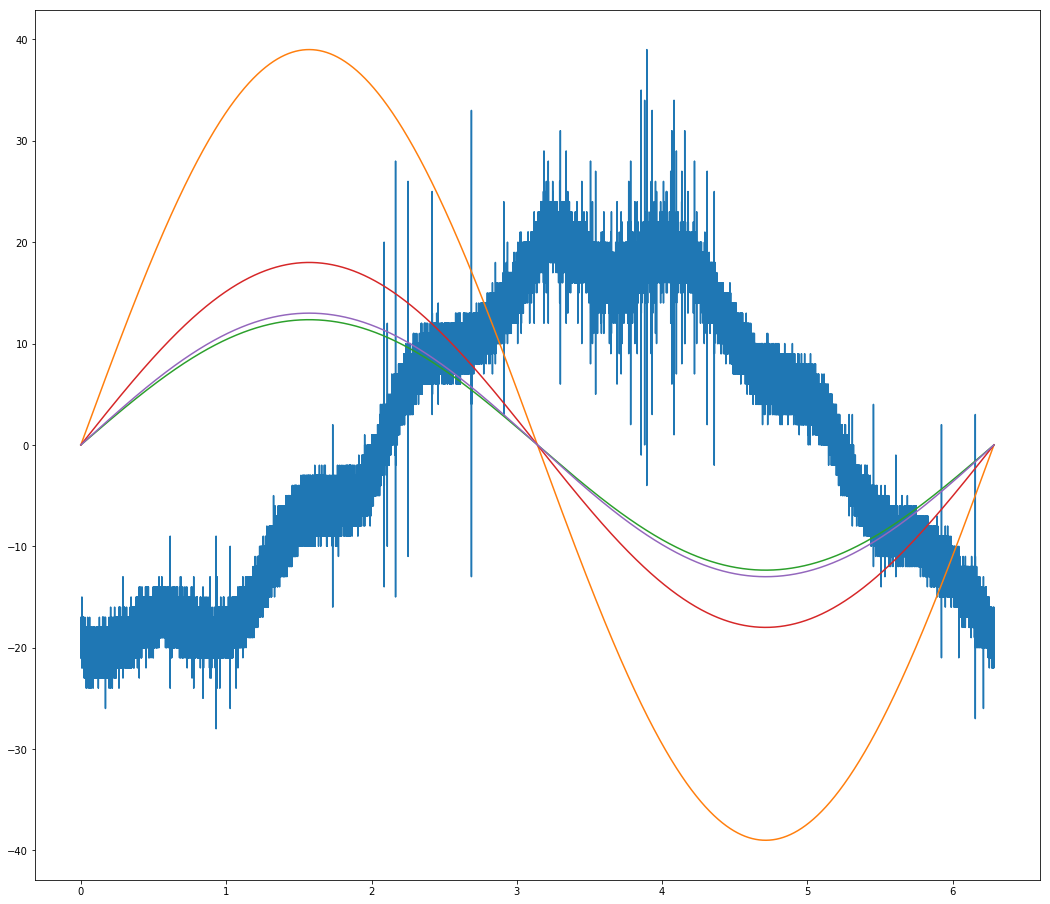

In [63]:
fig = plt.figure(figsize=(18, 16))
ax = fig.add_subplot(111)
#ax.plot(time_points, one_signal_1)
#ax.plot(time_points, one_signal_1_max_amplitude * np.cos(time_vector + 2 * np.pi / 3))
#ax.plot(time_points, one_signal_1_mean_amplitude * np.cos(time_vector + 2 * np.pi / 3))
#ax.plot(time_points, one_signal_1_max_amplitude * np.sin(time_vector))
#ax.plot(time_points, one_signal_1_mean_amplitude * np.sin(time_vector))
#ax.plot(time_points, one_signal_1_mode_amplitude * np.sin(time_vector))

ax.plot(time_vector, one_signal_2)
#ax.plot(time_points, one_signal_1_max_amplitude * np.cos(time_vector + 2 * np.pi / 3))
#ax.plot(time_points, one_signal_1_mean_amplitude * np.cos(time_vector + 2 * np.pi / 3))
ax.plot(time_vector, one_signal_2_max_amplitude * np.sin(time_vector))
ax.plot(time_vector, one_signal_2_mean_amplitude * np.sin(time_vector))
ax.plot(time_vector, one_signal_2_mode_amplitude * np.sin(time_vector))
ax.plot(time_vector, one_signal_2_median_amplitude * np.sin(time_vector))

#ax.plot(time_vector, one_signal_1_max_amplitude * np.cos(time_vector))
#ax.plot(time_vector, one_signal_1_mean_amplitude * np.cos(time_vector))
#ax.plot(time_vector, one_signal_1_mode_amplitude * np.cos(time_vector))

In [64]:
grouped_by_id_measurement = metadata_train_df.groupby('id_measurement')

In [107]:
#for item in grouped_by_id_measurement:
#   print(item)

In [66]:
%%timeit
one_signal_0_abs = one_signal_0[one_signal_0 >= 0]
one_signal_0_abs = -one_signal_0[one_signal_0 < 0]

3.83 ms ± 30.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [85]:
#one_signal_0

In [84]:
#one_signal_0[one_signal_0 < 0]

In [69]:
#one_signal_0_abs[one_signal_0_abs < 0]

Series([], Name: 0, dtype: int64)

In [70]:
comparison_result = []
for raw_value, abs_value in zip (one_signal_0, one_signal_0_abs):
    if raw_value == abs_value:
        comparison_result.append(raw_value == abs_value)
    else:
        comparison_result.append(raw_value == -abs_value)

In [71]:
all(comparison_result)

True

In [72]:
len(comparison_result)

800000

In [73]:
#z = np.zeros(800000)

In [74]:
#z.shape

In [75]:
#abs_initial_dict = {column_name: }

In [76]:
train_df_abs = pd.DataFrame(dtype=np.int8)

In [77]:
start_time = time.time()
#for column_name in train_df.columns.tolist()[:10]:
for column_name in train_df.columns.tolist():
    #train_df_column = train_df[column_name]
    #train_df_abs[column_name] = train_df_column[train_df_column >= 0]
    #train_df_abs[column_name] = -train_df_column[train_df_column < 0]
    #train_df_abs[column_name].astype(np.int8, copy=False)
    train_df_abs[column_name] = train_df[column_name].abs()
train_df_abs = train_df_abs.astype(np.int8)
run_time = time.time() - start_time
print("run time in seconds {}, in minutes {} ".format(run_time, run_time / 60))

run time in seconds 276.6350910663605, in minutes 4.610584851106008 


In [114]:
#train_df.iloc[:, 3]

In [115]:
#train_df_abs.iloc[:, 3]

In [80]:
#pd.DataFrame?

In [81]:
train_df_abs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Columns: 8712 entries, 0 to 8711
dtypes: int8(8712)
memory usage: 6.5 GB


In [82]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Columns: 8712 entries, 0 to 8711
dtypes: int8(8712)
memory usage: 6.5 GB


In [83]:
#one_signal_0.abs?

In [103]:
def get_signals_grouped_by_id_meausurement(id_measurement, metadata_df, signals_df):
    signals_atributes = metadata_df[metadata_df['id_measurement'] == id_measurement]
    signals_ids = signals_atributes['signal_id']
    signals_ids = signals_ids.astype(np.str)
    signals = signals_df[signals_ids]
    
    return {id_measurement: {'signal_atributes': signals_atributes, 'signals': signals}}

In [104]:
grouped_by_id_signals = get_signals_grouped_by_id_meausurement(1, metadata_train_df, train_df)

In [116]:
#grouped_by_id_signals

In [106]:
grouped_by_id_signals[1]['signal_atributes']

,signal_id,id_measurement,phase,target
3,3,1,0,1
4,4,1,1,1
5,5,1,2,1


Попробовать разные комбинации mean, median, mode, max, для каждого сигнала в качестве амплитуды.

In [118]:
metadata_train_df.isna().all()

signal_id         False
id_measurement    False
phase             False
target            False
dtype: bool

In [120]:
#train_df.isna().all()

In [132]:
train_signals_modes = train_df.mode()

In [133]:
train_signals_modes.shape

(2, 8712)

In [134]:
train_signals_modes.head()

,0,1,2,3,4,5,6,7,8,9,...,8702,8703,8704,8705,8706,8707,8708,8709,8710,8711
0,18.0,-17.0,-18.0,-19.0,-17.0,-18.0,18.0,-23.0,-20.0,20.0,...,-19.0,18.0,19.0,-20.0,-20.0,16.0,18.0,18.0,19.0,-20.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [135]:
train_signals_modes_row_1 = train_signals_modes.iloc[1]

In [136]:
train_signals_modes_row_1_not_nan = train_signals_modes_row_1[modes.isna == False]

In [137]:
train_signals_modes_row_1_not_nan.shape

()

In [139]:
train_signals_modes = train_signals_modes.iloc[0]

In [140]:
train_signals_means = train_df.mean()

In [141]:
train_signals_means

0      -0.960271
1      -0.194125
2      -0.043555
3      -0.997401
4      -0.175586
5      -0.036004
6      -1.146185
7      -1.952695
8       0.873370
9      -1.359634
10      0.728509
11     -0.817065
12     -1.011068
13     -0.153133
14     -0.030229
15     -1.010104
16     -0.172026
17     -0.034221
18     -1.071144
19     -1.936465
20      0.895243
21     -1.370572
22      0.714174
23     -0.796930
24     -0.977525
25     -0.189996
26     -0.047001
27     -0.968560
28     -0.180809
29     -0.061299
          ...   
8682   -0.994912
8683   -0.167106
8684   -0.053012
8685   -0.009571
8686   -1.488951
8687   -1.439861
8688   -1.059704
8689   -1.940971
8690    0.876066
8691   -0.015636
8692   -1.479125
8693   -1.448819
8694   -0.012355
8695   -1.486533
8696   -1.455188
8697   -1.380681
8698    0.737741
8699   -0.796041
8700    0.014982
8701   -1.470319
8702   -1.467915
8703   -1.204320
8704   -1.915537
8705    0.886576
8706    0.001186
8707   -1.465155
8708   -1.473611
8709   -1.0034

In [142]:
train_signals_medians = train_df.median()

In [ ]:
#train_signals_variations = train_df.var()